In [2]:
from diffusers import StableDiffusionPipeline

device = 'cuda'

In [3]:
import torch

def get_prediction(pipe: StableDiffusionPipeline):
    prompt = "a drawing of a girl with a boxing glove"
    with torch.no_grad():
        images = pipe(prompt, height=256, width=256).images

    return images[0]


In [3]:
!python diff_hugging.py

Using custom data configuration lambdalabs--pokemon-blip-captions-10e3527a764857bd
Found cached dataset parquet (/home/marcin/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration lambdalabs--pokemon-blip-captions-10e3527a764857bd
Found cached dataset parquet (/home/marcin/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
The config attributes {'predict_epsilon': True} were passed to DDPMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/trained_poke_2
/home/marcin/Documents/mgr/s

The config attributes {'predict_epsilon': True} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


models/trained_poke_2_pipeline


100%|██████████| 50/50 [00:03<00:00, 12.60it/s]


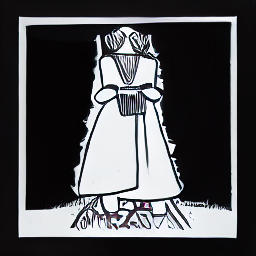

In [6]:
import os

from config import CHECKPOINTS_DIR, MODEL_NAME

path = os.path.join(CHECKPOINTS_DIR, f'{MODEL_NAME}_pipeline')
print(path)
pipeline = StableDiffusionPipeline.from_pretrained(path).to(device)
pipeline.safety_checker = None
get_prediction(pipeline)

100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


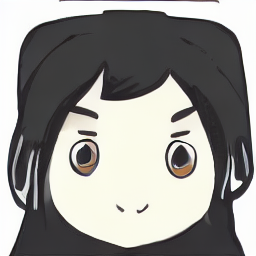

In [15]:
get_prediction(pipeline)